In [51]:
import numpy as np
import xarray as xr
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable

import iris
import iris.analysis.cartography
import iris.plot as iplt
import iris.quickplot as qplt


from glob import glob
from datetime import timedelta as delta
from datetime import datetime

from parcels import (grid, Field, FieldSet, ParticleSet, JITParticle, AdvectionRK4,
                     ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)

from importlib import reload
import dTools

In [38]:
reload(dTools)

<module 'dTools' from '/Users/daanreijnders/surfdrive/Thesis/repo/EEZ/dTools.py'>

In [18]:
# Load and add velocity field
datadir = '/Users/daanreijnders/Datasets/'
field_file = 'daily_CESM_0.1degree_controlrun_year_300_arctic_region_timed.nc'
def read_velocity_field(ufiles):
    filenames = {'U': {'lon': ufiles,
                       'lat': ufiles,
                       'data':ufiles},
                 'V': {'lon': ufiles,
                       'lat': ufiles,
                       'data':ufiles}}

    variables = {'U': 'UVEL_5m',
                 'V': 'VVEL_5m'}

    dimensions = {'U': {'time': 'time',
                        'lat': 'ULAT',
                        'lon': 'ULON'},
                  'V': {'time': 'time',
                        'lat': 'ULAT',
                        'lon': 'ULON'}}
    fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, allow_time_extrapolation=False)

    fieldset.U.set_scaling_factor(0.01)  #convert cm/s to m/s
    fieldset.V.set_scaling_factor(0.01)
    fieldset.U.vmax = 10;  fieldset.U.vmin = -10;  # set max of flow to 10 m/s
    fieldset.V.vmax = 10; fieldset.V.vmin = -10;
    return fieldset

fieldset = read_velocity_field(datadir+field_file)  

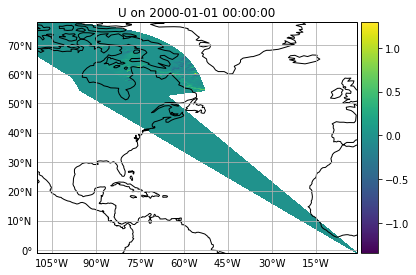

In [7]:
fieldset.U.show()

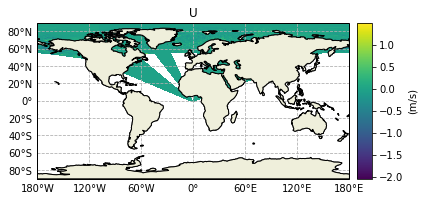

In [40]:
dTools.show(fieldset.U)

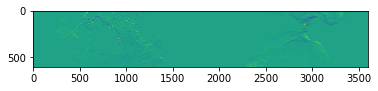

In [31]:
plt.imshow(fieldset.U.data[0,:,:])

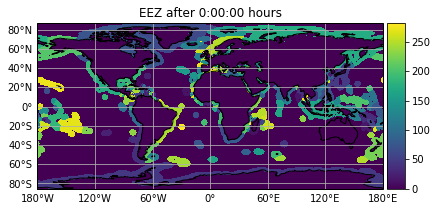

In [21]:
# Load and add EEZ field
EEZ_ds = xr.open_dataset('EEZ_export.nc')
EEZ = EEZ_ds['EEZ'][:,:]
EEZ_lats = EEZ_ds['latitude'].data
EEZ_lons = EEZ_ds['longitude'].data

EEZ_field = Field(name="EEZ", data=EEZ.data, mesh='spherical', lon=EEZ_lons, lat=EEZ_lats, allow_time_extrapolation=True)
fieldset.add_field(EEZ_field)

fieldset.EEZ.show()

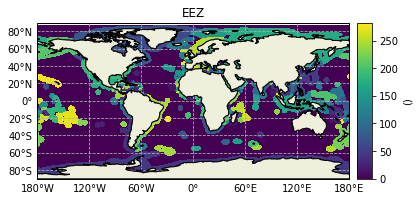

In [24]:
show(fieldset.EEZ)

In [47]:
# Kernels and particleclasses
class myParticle(JITParticle):
        EEZ = Variable('EEZ', dtype=np.int32, to_write=True)

def EEZ_sampler(particle, fieldset, time):
    particle.EEZ = fieldset.EEZ[time, 0., particle.lat, particle.lon]
    
def periodicBC(particle, fieldSet, time):
    if particle.lon > 360.:
        particle.lon -= 360.        
    if particle.lon < 0.:
        particle.lon += 360.  

def OutOfBounds(particle, fieldset, time):
    particle.delete()

In [48]:
# Specify release times and locations
release_times = np.array([datetime(2000, 1, 1) + delta(days=x) for x in range(0, int(365*1))])
release_lons = np.full(len(release_times), 3)
release_lats = np.full(len(release_times), 75)

In [64]:
# Initialize and run fieldset
pset = ParticleSet.from_list(fieldset=fieldset, pclass=myParticle, lon=release_lons, lat=release_lats, 
                       time = release_times)
pfile = ParticleFile('pFileEEZ', pset, outputdt=delta(hours=6))
kernels = pset.Kernel(AdvectionRK4) #+ EEZ_sampler
pset.execute(kernels, \
             runtime=delta(days=365), \
             dt = delta(minutes=5), \
             output_file = pfile, \
             verbose_progress = True, \
             recovery={ErrorCode.ErrorOutOfBounds: OutOfBounds})

INFO: Compiled myParticleAdvectionRK4 ==> /var/folders/k_/m82s7xk97dlgd2rcy0bn6v100000gn/T/parcels-501/afc89a50a33d605ccbf91ea98536ff20.so
 99% (31276800.0 of 31536000.0) |####### | Elapsed Time: 0:02:47 ETA:   0:00:00WARNING: ParticleSet is empty on writing as array at time 3.14712e+07
100% (31536000.0 of 31536000.0) |########| Elapsed Time: 0:02:47 Time:  0:02:47


In [65]:
plotTrajectoriesFile('pFileEEZ.nc', mode='movie2d_notebook')

/Users/daanreijnders/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/matplotlib/axes/_base.py:3152: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=3.0, right=3.0
  'left=%s, right=%s') % (left, right))
/Users/daanreijnders/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/matplotlib/axes/_base.py:3471: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=75.0, top=75.0
  'bottom=%s, top=%s') % (bottom, top))


In [44]:
# Investigate data. Which EEZs are visited?
pfile = xr.open_dataset('pFileEEZ.nc', decode_cf=True)
uniques, counts = np.unique(np.where(np.isnan(pfile['EEZ'].data), -1, pfile['EEZ'].data), return_counts=True)
bardict = dict(zip(uniques, counts))
str(np.ma.filled(pfile.variables['time'], np.nan)[0][0])[:13]

ValueError: unable to decode time units 'seconds since 2000-01-01T00:00:00.000000000' with calendar 'np_datetime64'. Try opening your dataset with decode_times=False.

In [13]:
def particle_anim(pfile, fps=24):
    # Load arrays from file
    lon = np.ma.filled(pfile.variables['lon'], np.nan)
    lat = np.ma.filled(pfile.variables['lat'], np.nan)
    time = np.ma.filled(pfile.variables['time'], np.nan)
    EEZ_evol = np.ma.filled(pfile.variables['z'], np.nan)
    mesh = pfile.attrs['parcels_mesh'] if 'parcels_mesh' in pfile.attrs else 'spherical'
    pfile.close()
    
    # Create figure
    fig     = plt.figure(figsize=(9,5))
    particle_map = plt.subplot(projection=ccrs.PlateCarree())   
    
    # Add background for land plot
    particle_map.set_extent((-10,20,50,80), crs=ccrs.PlateCarree())
    particle_map.coastlines()
    particle_map.add_feature(cart.feature.LAND, zorder=5, edgecolor='k')
    particle_map.pcolor(EEZ_lons, EEZ_lats, EEZ, transform=ccrs.PlateCarree(), cmap='Set3', zorder=1)
    gl = particle_map.gridlines(crs=ccrs.PlateCarree(), linestyle='--', draw_labels = True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    plottimes = np.unique(time)
    if isinstance(plottimes[0], (np.datetime64, np.timedelta64)):
        plottimes = plottimes[~np.isnat(plottimes)]
    else:
        try:
            plottimes = plottimes[~np.isnan(plottimes)]
        except:
            pass
    currtime = time == plottimes[0]
    
    scat   = particle_map.scatter(lon[currtime], lat[currtime], s=20, color='k', transform=ccrs.Geodetic())
    
    # Specify EEZs for bar chart
    targets = [0, 210, 218, 223] # -1 for NaN
    # Count instances of particles at EEZ in target list at a certain timestep
    def EEZ_counter(timestep):
        currEEZ = np.where(np.isnan(pfile['EEZ'].data[timestep]), -1, pfile['EEZ'].data[timestep])
        currCount = np.zeros(len(targets))
        for el in currEEZ:
            try:
                idx = targets.index(el)
                currCount[idx] += 1
            except ValueError:
                pass
        return currCount
    
    divider = make_axes_locatable(particle_map)
    barplot = divider.append_axes("right", size=2, pad=1, axes_class=plt.Axes)
    
    bar    = barplot.barh(np.arange(len(targets)), EEZ_counter(currtime))
    barplot.set_xlim(0, 40)
    barplot.set_yticks(np.arange(len(targets)))
    barplot.set_yticklabels(['No EEZ' if label == -1 else str(label) for label in targets])
    barplot.set_ylabel('EEZ ID')
    barplot.set_xlabel('Count')
    barplot.invert_yaxis()
    titel = fig.suptitle('Particles at time ' + str(plottimes[0])[:13])
    frames = np.arange(0, len(plottimes))

    def animate(t):
        currtime = time == plottimes[t]
        scat.set_offsets(np.vstack((lon[currtime], lat[currtime])).transpose())
        titel.set_text('Particles in different EEZs at time ' + str(plottimes[t])[:13])
        for rect, width in zip(bar, EEZ_counter(currtime)):
            rect.set_width(width)
        return scat,
    anim = animation.FuncAnimation(fig, animate, interval=20, blit=False)  #Frames, init_func=init
    anim.save('particle_EEZ_evo.mp4', fps=fps, metadata={'artist':'Daan', 'title':'Particles in EEZs'}, extra_args=['-vcodec', 'libx264'])
    
    plt.show()
    plt.close()

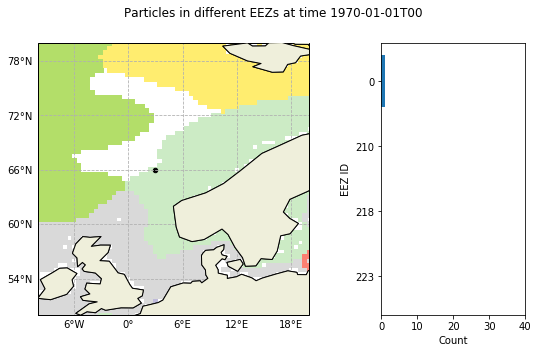

In [14]:
particle_anim(pfile)